# Melanoma Prediction

# Importing Libraries

In [3]:
import numpy as np
import random
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
from imutils import paths
import cv2
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import os
from PIL import ImageFile

from keras.models import Sequential
from keras.layers import Activation,Dropout,Flatten,Conv2D,MaxPooling2D,Dense,concatenate
from tensorflow.keras import layers

from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import keras
from tensorflow.keras.optimizers import Adam

2023-05-02 00:34:42.127354: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-02 00:34:42.238807: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 00:34:43.050543: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Preparing & Accessing data

In [4]:
df_gt = pd.read_csv("data/ISIC_2019_Training_GroundTruth.csv")
df_gt.sample(5)

image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
23068  ISIC_0069639  0.0  0.0  1.0  0.0  0.0  0.0   0.0  0.0  0.0
25186  ISIC_0073030  0.0  0.0  0.0  0.0  0.0  0.0   0.0  1.0  0.0
9887   ISIC_0031290  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
12969  ISIC_0053535  0.0  0.0  1.0  0.0  0.0  0.0   0.0  0.0  0.0
10551  ISIC_0031954  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0

In [5]:
df_md = pd.read_csv("data/ISIC_2019_Training_Metadata.csv")
df_md['target'] = df_gt['MEL']
df_md.sample(5)

image  age_approx anatom_site_general    lesion_id     sex   
3591   ISIC_0024994        40.0     lower extremity  HAM_0002960  female  \
21531  ISIC_0067265        65.0      anterior torso  BCN_0002603    male   
20947  ISIC_0066347        70.0      anterior torso  BCN_0005715    male   
22959  ISIC_0069472        70.0     lower extremity  BCN_0004820    male   
18467  ISIC_0062357        45.0      anterior torso  BCN_0004845    male   

       target  
3591      0.0  
21531     0.0  
20947     1.0  
22959     0.0  
18467     0.0

In [6]:
#Preparing directories for DataImage Generator
os.makedirs("Training_Data/MEL0")
os.makedirs("Test_Data/MEL0")
os.mkdir('./Test_Data/MEL1')
os.mkdir('./Training_Data/MEL1')

FileExistsError: [Errno 17] File exists: 'Training_Data/MEL0'

In [ ]:
#Function to populate train and test directories
import shutil
import sys
def Make_Dir(src, dst, Data):
    Labels = Data[['image','target']]
    for imagename, target in Labels.values:
        src_path = src + '/'+ imagename + '.jpg'
        dst_path = dst + '/' + 'MEL' + str(int(target))
        try:
            shutil.copy(src_path, dst_path)
            #print("sucessfully copied " + imagename + ' from src ' + src_path + " to dst " + dst_path)    
        except IOError as e:
            print("Unable to copy file {} to {}".format(src_path, dst_path))
            break
        except:
            print("when try copy file {} to {}, unexpected error: {}".format(src_path, dst_path, sys.exc_info()))
            break

In [ ]:
#Stratified data sampling since dataset is unbalanced we need same percentage of classes in training and testing data
Test_data =df_md.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.2,random_state=0))
Training_data = df_md.drop(Test_data.index)

In [7]:
Make_Dir('data/ISIC_2019_Training_Input/ISIC_2019_Training_Input','./Training_Data', Training_data)
Make_Dir('data/ISIC_2019_Training_Input/ISIC_2019_Training_Input','./Test_Data',Test_data )

In [8]:
#Check directories inside train and test directories
print("Test")
print(os.listdir('./Test_Data'))
print()
print("Test MEL0")
print(os.listdir('./Test_Data/MEL0')[0:5])
print()
print("Test MEL1")
print(os.listdir('./Test_Data/MEL1')[0:5])
print()                             
print("Training")
print(os.listdir('./Training_Data'))
print()                 
print("Training MEL0")
print(os.listdir('./Training_Data/MEL0')[0:5])
print()                
print("Training MEL1")
print(os.listdir('./Training_Data/MEL1')[0:5])

Test
['MEL0', 'MEL1']

Test MEL0
['ISIC_0000010.jpg', 'ISIC_0000011.jpg', 'ISIC_0000016.jpg', 'ISIC_0000020_downsampled.jpg', 'ISIC_0000023_downsampled.jpg']

Test MEL1
['ISIC_0000004.jpg', 'ISIC_0000152_downsampled.jpg', 'ISIC_0000154_downsampled.jpg', 'ISIC_0000155_downsampled.jpg', 'ISIC_0000157.jpg']

Training
['MEL0', 'MEL1']

Training MEL0
['ISIC_0000000.jpg', 'ISIC_0000001.jpg', 'ISIC_0000003.jpg', 'ISIC_0000006.jpg', 'ISIC_0000007.jpg']

Training MEL1
['ISIC_0000002.jpg', 'ISIC_0000013.jpg', 'ISIC_0000022_downsampled.jpg', 'ISIC_0000026_downsampled.jpg', 'ISIC_0000029_downsampled.jpg']


In [9]:
imagaPaths = list(paths.list_images('./Training_Data'))
len(imagaPaths)

20265

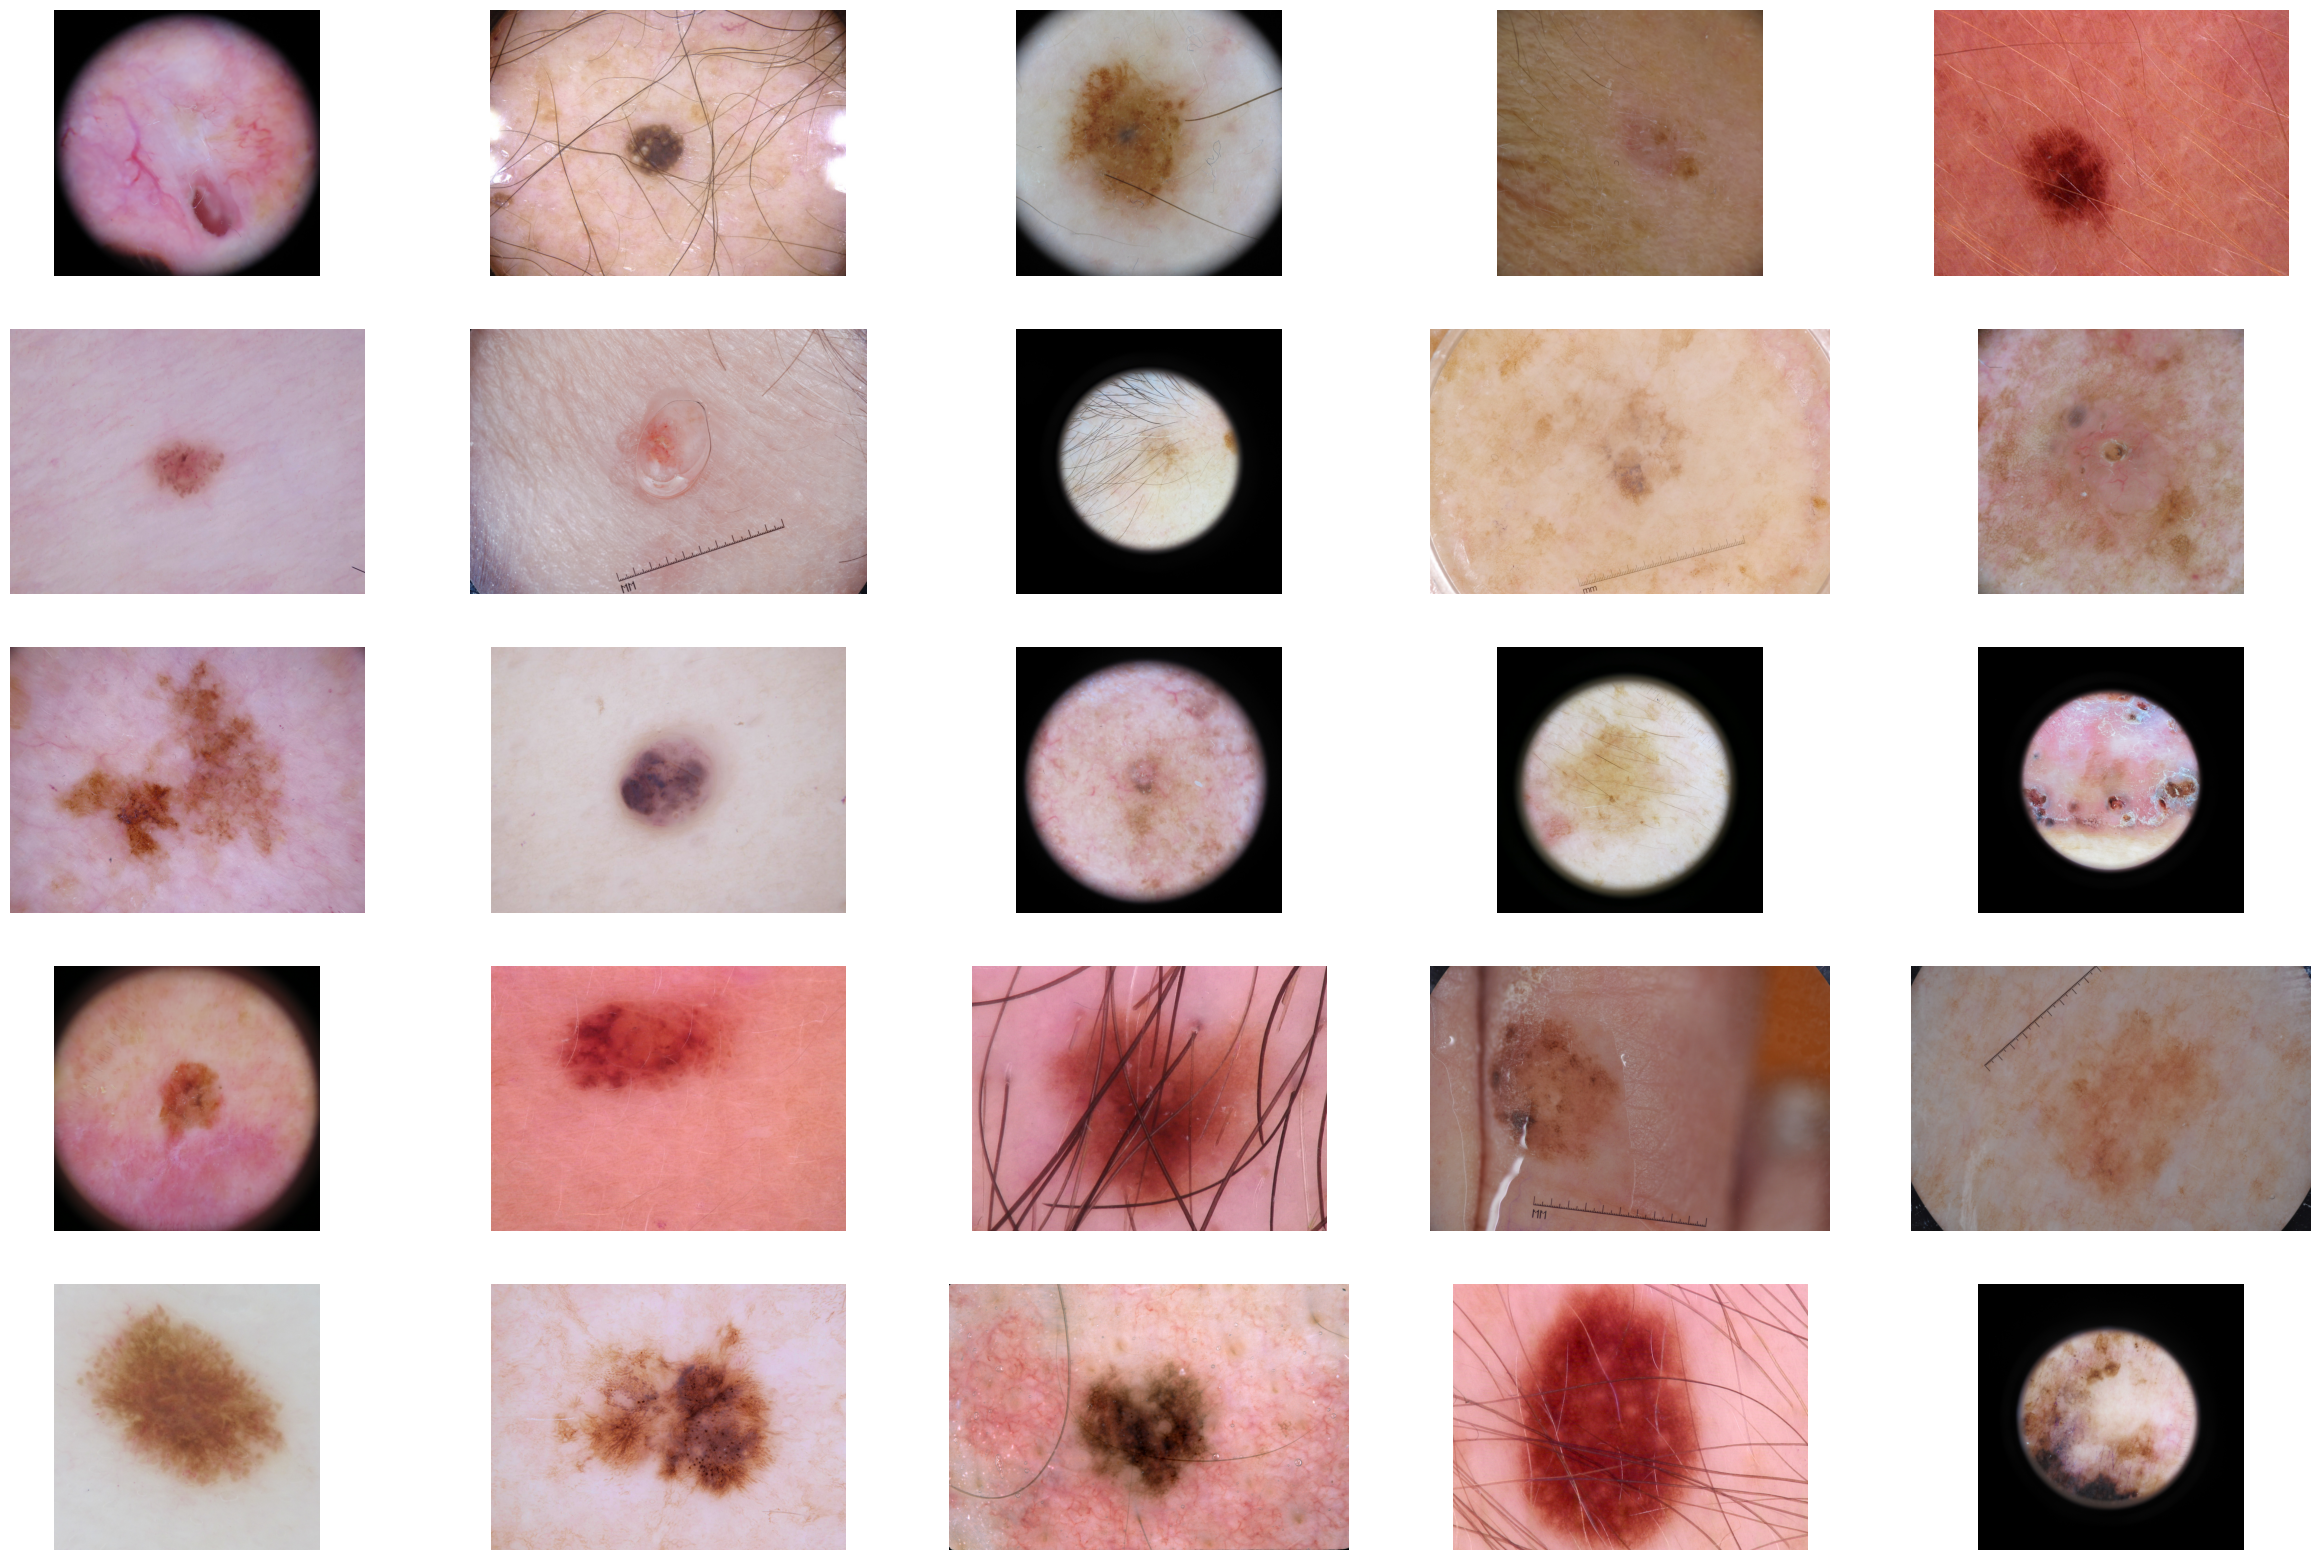

In [10]:
#visualizing some random images
the_array = random.sample(imagaPaths , 25)
the_array
plt.figure(figsize=(30,20)) # specifying the overall grid size

for i in range(25):
    plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(np.asarray(plt.imread(the_array[i])))
    plt.axis('off') 
plt.show()

In [11]:
df_gt.isnull().sum()

image    0
MEL      0
NV       0
BCC      0
AK       0
BKL      0
DF       0
VASC     0
SCC      0
UNK      0
dtype: int64

In [12]:
df_md.isnull().sum()

image                     0
age_approx              437
anatom_site_general    2631
lesion_id              2084
sex                     384
target                    0
dtype: int64

#### data contains null values

In [13]:
import seaborn as sns
sns.countplot(y='target', data=df_md)

ModuleNotFoundError: No module named 'seaborn'

#### Data is imbalanced, solved further in the notebook using sklearn class weight

# Stratified Sampling (Spilting data)

In [15]:
#Stratified data sampling since dataset is unbalanced we need same percentage of classes in training and testing data
Test_data =df_md.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.2,random_state=0))
Training_data = df_md.drop(Test_data.index)

# Building ImageDataGenerator

In [16]:
#Defining ImageDataGenerator
image_gen = ImageDataGenerator(rotation_range = 30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rescale= 1/255,
                               shear_range=0.1,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode= 'nearest',
                               validation_split=0.2)

#### Images without ImageDataGenerator

In [17]:
#visualizing some random images
the_array = random.sample(imagaPaths , 12)
plt.figure(figsize=(30,10)) # specifying the overall grid size

for i in range(12): 
    plt.subplot(2,6,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(np.asarray(plt.imread(the_array[i])))  
    plt.axis('off') 
plt.show()

#### Images after applying ImageDataGenerator

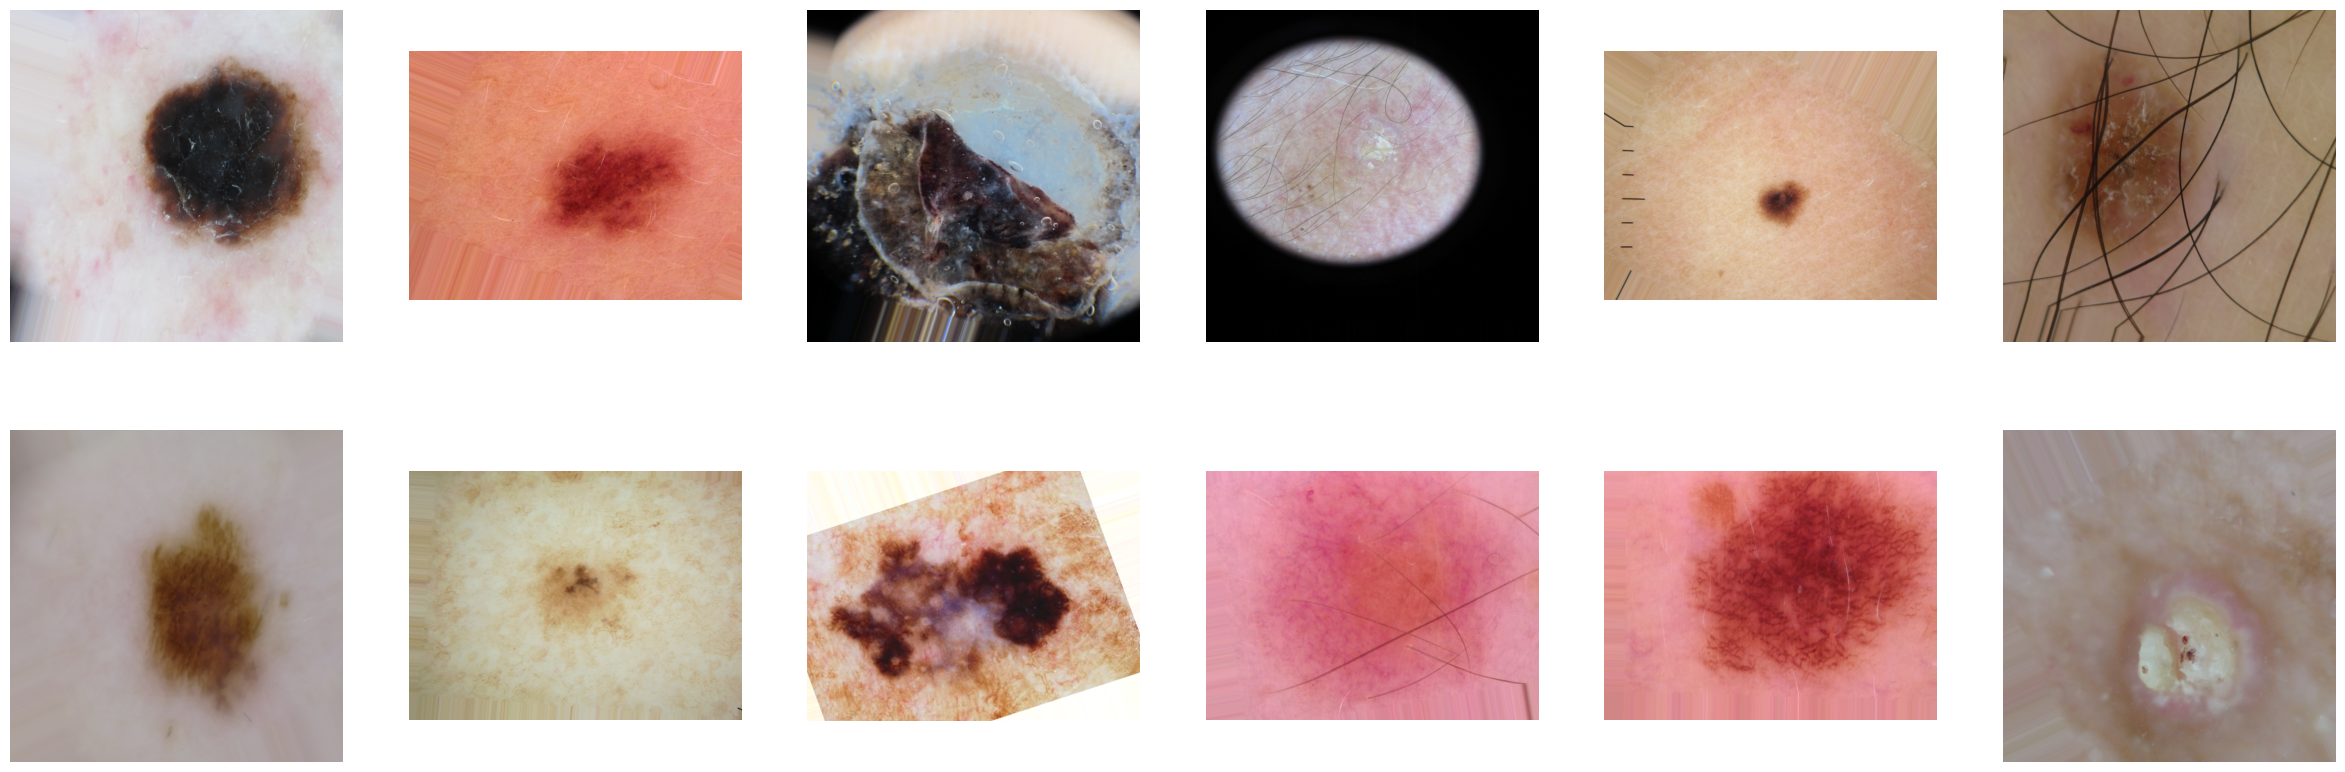

In [18]:
#visualizing same images but transformed
plt.figure(figsize=(30,10)) # specifying the overall grid size

for i in range(12):
    plt.subplot(2,6,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(image_gen.random_transform(np.asarray(plt.imread(the_array[i]))))
    plt.axis('off') 
plt.show()

#### it makes slight changes in images in each epoch

# Building model

In [19]:
input_shape = (150,150,3)
batch_size = 64

In [20]:
model = Sequential()

model.add(layers.Conv2D(32, (3,3), input_shape = input_shape , activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(256, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 36, 36, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)      

In [21]:
train_image_gen = image_gen.flow_from_directory('./Training_Data',
                                                target_size = input_shape[0:2],
                                               batch_size = batch_size,
                                               class_mode = 'binary')

Found 20265 images belonging to 2 classes.


In [22]:
test_image_gen = image_gen.flow_from_directory('./Test_Data',
                                                target_size = input_shape[0:2],
                                               batch_size = batch_size,
                                               class_mode = 'binary')

Found 5066 images belonging to 2 classes.


In [23]:
valid_image_gen = image_gen.flow_from_directory('./Training_Data',
                                                target_size = input_shape[0:2],
                                               batch_size = batch_size,
                                               class_mode = 'binary',
                                               subset='validation')

Found 4052 images belonging to 2 classes.


In [24]:
train_image_gen.class_indices

{'MEL0': 0, 'MEL1': 1}

In [25]:
#Solving imbalaced data by class weight
class_weights = class_weight.compute_class_weight( 'balanced', classes=np.unique(test_image_gen.classes),  y=test_image_gen.classes)
train_class_weights = dict(enumerate(class_weights))

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)

results = model.fit(train_image_gen,epochs=100,class_weight=train_class_weights,validation_data=valid_image_gen,callbacks=[early_stopping_monitor])

Epoch 1/100


2023-05-02 00:33:06.870709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-02 00:33:07.789828: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


In [1]:
score = model.evaluate(test_image_gen, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

NameError: name 'model' is not defined

#### accuracy is pretty good, but lets try without image generator

# Preparing Data for the model without ImageDataGenerator

In [26]:
df_md['target'] = df_md['target'].astype('int')
df_md

image  age_approx anatom_site_general    lesion_id     sex   
0      ISIC_0000000        55.0      anterior torso          NaN  female  \
1      ISIC_0000001        30.0      anterior torso          NaN  female   
2      ISIC_0000002        60.0     upper extremity          NaN  female   
3      ISIC_0000003        30.0     upper extremity          NaN    male   
4      ISIC_0000004        80.0     posterior torso          NaN    male   
...             ...         ...                 ...          ...     ...   
25326  ISIC_0073247        85.0           head/neck  BCN_0003925  female   
25327  ISIC_0073248        65.0      anterior torso  BCN_0001819    male   
25328  ISIC_0073249        70.0     lower extremity  BCN_0001085    male   
25329  ISIC_0073251        55.0         palms/soles  BCN_0002083  female   
25330  ISIC_0073254        50.0     upper extremity  BCN_0001079    male   

       target  
0           0  
1           0  
2           1  
3           0  
4           1  
...       ...  
25326       0  
25327       0  
25328       1  
25329       0  
25330       0  

[25331 rows x 6 columns]

In [27]:
#Preparing data to the model without DataImageGenerator
list_of_paths = []
list_of_names = []
for name in sorted(os.listdir('data/ISIC_2019_Training_Input/ISIC_2019_Training_Input')):
    no_jpg_name = name[:-4]
    path ='data/ISIC_2019_Training_Input/ISIC_2019_Training_Input/' + name
    list_of_paths.append(path)
    list_of_names.append(no_jpg_name)
list_of_paths[0:2]

['data/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ATTRIBUTION.txt',
 'data/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000000.jpg']

In [28]:
list_of_names[0:2]

['ATTRIBUTION', 'ISIC_0000000']

In [29]:
list_1 = df_md['image'].values.tolist()
list_1[0:2]

['ISIC_0000000', 'ISIC_0000001']

In [30]:
main_list = list(set(list_of_names) - set(list_1))
main_list

['LICENSE', 'ATTRIBUTION']

In [31]:
#Removing non image directories
list_of_paths.remove("data/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ATTRIBUTION.txt")
list_of_paths.remove("data/ISIC_2019_Training_Input/ISIC_2019_Training_Input/LICENSE.txt")

In [32]:
df_md.insert(0,'path', list_of_paths)

### Taking a sample because my notebook runs out of memory

In [33]:
df_md2=df_md.sample(frac = 0.2)
df_md2

path   
16723  data/ISIC_2019_Training_Input/ISIC_2019_Traini...  \
14618  data/ISIC_2019_Training_Input/ISIC_2019_Traini...   
5510   data/ISIC_2019_Training_Input/ISIC_2019_Traini...   
17678  data/ISIC_2019_Training_Input/ISIC_2019_Traini...   
13751  data/ISIC_2019_Training_Input/ISIC_2019_Traini...   
...                                                  ...   
581    data/ISIC_2019_Training_Input/ISIC_2019_Traini...   
3038   data/ISIC_2019_Training_Input/ISIC_2019_Traini...   
12198  data/ISIC_2019_Training_Input/ISIC_2019_Traini...   
5142   data/ISIC_2019_Training_Input/ISIC_2019_Traini...   
22007  data/ISIC_2019_Training_Input/ISIC_2019_Traini...   

                          image  age_approx anatom_site_general    lesion_id   
16723              ISIC_0059567        80.0      anterior torso  BCN_0000204  \
14618              ISIC_0056209        35.0           head/neck  BCN_0001321   
5510               ISIC_0026913        40.0      anterior torso  HAM_0001134   
17678              ISIC_0061088        35.0           head/neck  BCN_0002179   
13751              ISIC_0054814        30.0     upper extremity  BCN_0001221   
...                         ...         ...                 ...          ...   
581    ISIC_0004168_downsampled        15.0                 NaN          NaN   
3038               ISIC_0024441        45.0     posterior torso  HAM_0007516   
12198              ISIC_0033601        40.0                 NaN  HAM_0003845   
5142               ISIC_0026545        55.0     posterior torso  HAM_0001299   
22007              ISIC_0068005        75.0     upper extremity  BCN_0004256   

          sex  target  
16723    male       0  
14618    male       1  
5510     male       0  
17678    male       0  
13751  female       0  
...       ...     ...  
581    female       0  
3038   female       0  
12198  female       0  
5142   female       1  
22007    male       0  

[5066 rows x 7 columns]

In [34]:
df_md2['pixels'] = df_md2['path'].map(lambda x: np.asarray(Image.open(x).resize((128,128))))

In [35]:
df_md2.head()

path         image   
16723  data/ISIC_2019_Training_Input/ISIC_2019_Traini...  ISIC_0059567  \
14618  data/ISIC_2019_Training_Input/ISIC_2019_Traini...  ISIC_0056209   
5510   data/ISIC_2019_Training_Input/ISIC_2019_Traini...  ISIC_0026913   
17678  data/ISIC_2019_Training_Input/ISIC_2019_Traini...  ISIC_0061088   
13751  data/ISIC_2019_Training_Input/ISIC_2019_Traini...  ISIC_0054814   

       age_approx anatom_site_general    lesion_id     sex  target   
16723        80.0      anterior torso  BCN_0000204    male       0  \
14618        35.0           head/neck  BCN_0001321    male       1   
5510         40.0      anterior torso  HAM_0001134    male       0   
17678        35.0           head/neck  BCN_0002179    male       0   
13751        30.0     upper extremity  BCN_0001221  female       0   

                                                  pixels  
16723  [[[158, 160, 169], [160, 163, 171], [163, 166,...  
14618  [[[1, 1, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
5510   [[[198, 168, 192], [199, 169, 194], [200, 167,...  
17678  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
13751  [[[188, 184, 185], [190, 188, 191], [192, 188,...

In [36]:
df_md2['pixels'] = df_md2['pixels']/255

In [37]:
yy = df_md2['target']

In [38]:
XX =  df_md2['pixels']

In [39]:
X_train_full, X_test, y_train_full, y_test = train_test_split(XX,yy, test_size=0.2,random_state=0,stratify = yy)

In [40]:
x_train_arr= np.asarray(X_train_full.tolist())
x_test_arr = np.asarray(X_test.tolist())

In [41]:
X_train, X_valid, y_train, y_valid = train_test_split(x_train_arr,y_train_full, test_size=0.2,random_state=0,stratify = y_train_full)

In [42]:
print("X_train dataset: ", X_train.shape)
print("y_train dataset: ", y_train.shape)
print("x_valid dataset: ", X_valid.shape)
print("y_valid dataset: ", y_valid.shape)
print("X_test dataset: ", x_test_arr.shape)
print("y_test dataset: ", y_test.shape)

X_train dataset:  (3241, 128, 128, 3)
y_train dataset:  (3241,)
x_valid dataset:  (811, 128, 128, 3)
y_valid dataset:  (811,)
X_test dataset:  (1014, 128, 128, 3)
y_test dataset:  (1014,)


In [43]:
pd.Series(y_train).value_counts()

target
0    2661
1     580
Name: count, dtype: int64

In [44]:
pd.Series(y_test).value_counts()

target
0    832
1    182
Name: count, dtype: int64

In [45]:
pd.Series(y_valid).value_counts()

target
0    666
1    145
Name: count, dtype: int64

In [46]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape =(128,128,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
          
model.add(Conv2D(filters=64,kernel_size=(3,3), input_shape =(128,128,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3), input_shape =(128,128,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
          
model.add(Flatten())
model.add(Dense(128,activation='sigmoid'))
          
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
          
model.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 64)      

In [48]:
class_weights = class_weight.compute_class_weight( 'balanced', classes=np.unique(y_train),  y=y_train)
train_class_weights = dict(enumerate(class_weights))

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)

results = model.fit(X_train, y_train, validation_data=(X_valid,y_valid),epochs=100, class_weight = train_class_weights, batch_size=64,callbacks=[early_stopping_monitor])

Epoch 1/100


In [48]:
score = model.evaluate(x_test_arr, y_test, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

32/32 [==============================] - 1s 14ms/step - loss: 0.6366 - accuracy: 0.6164
Test loss: 0.6366469264030457 / Test accuracy: 0.6163707971572876


#### with image generator the model gave a better accuracy, but note that this model aquired this accuracy with only 20% of the data

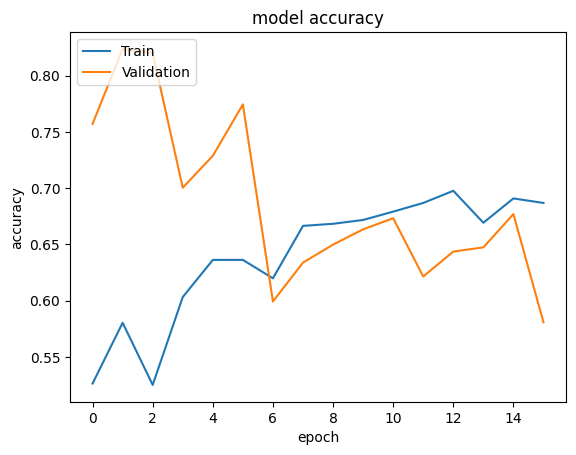

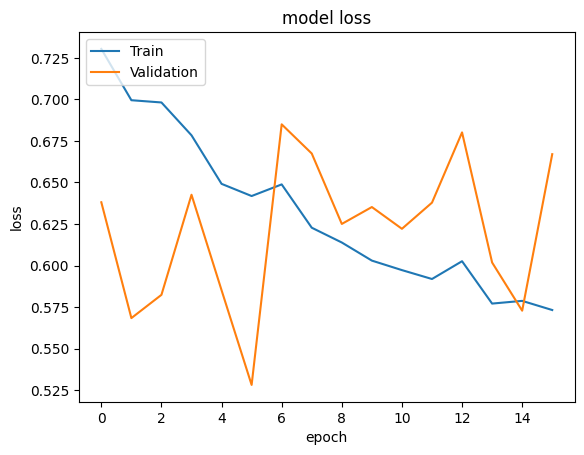

In [49]:
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [50]:
pd.DataFrame(results.history).plot(figsize=(40,15))
plt.show()

# Preprocessing (age & sex) columns

In [51]:
df_md

path         image   
0      data/ISIC_2019_Training_Input/ISIC_2019_Traini...  ISIC_0000000  \
1      data/ISIC_2019_Training_Input/ISIC_2019_Traini...  ISIC_0000001   
2      data/ISIC_2019_Training_Input/ISIC_2019_Traini...  ISIC_0000002   
3      data/ISIC_2019_Training_Input/ISIC_2019_Traini...  ISIC_0000003   
4      data/ISIC_2019_Training_Input/ISIC_2019_Traini...  ISIC_0000004   
...                                                  ...           ...   
25326  data/ISIC_2019_Training_Input/ISIC_2019_Traini...  ISIC_0073247   
25327  data/ISIC_2019_Training_Input/ISIC_2019_Traini...  ISIC_0073248   
25328  data/ISIC_2019_Training_Input/ISIC_2019_Traini...  ISIC_0073249   
25329  data/ISIC_2019_Training_Input/ISIC_2019_Traini...  ISIC_0073251   
25330  data/ISIC_2019_Training_Input/ISIC_2019_Traini...  ISIC_0073254   

       age_approx anatom_site_general    lesion_id     sex  target  
0            55.0      anterior torso          NaN  female       0  
1            30.0      anterior torso          NaN  female       0  
2            60.0     upper extremity          NaN  female       1  
3            30.0     upper extremity          NaN    male       0  
4            80.0     posterior torso          NaN    male       1  
...           ...                 ...          ...     ...     ...  
25326        85.0           head/neck  BCN_0003925  female       0  
25327        65.0      anterior torso  BCN_0001819    male       0  
25328        70.0     lower extremity  BCN_0001085    male       1  
25329        55.0         palms/soles  BCN_0002083  female       0  
25330        50.0     upper extremity  BCN_0001079    male       0  

[25331 rows x 7 columns]

In [52]:
XXX = df_md.drop(['image','lesion_id','target','anatom_site_general','path'],axis=1)
yyy = df_md['target']

cleanup_nums = {"sex":     {"male": 1, "female": 0,np.nan : 2}}
XXX=XXX.replace(cleanup_nums)

In [53]:
XXX.sample(5)

age_approx  sex
12140        45.0  1.0
12709        30.0  0.0
22137        10.0  1.0
10643        75.0  1.0
15710        75.0  1.0

In [54]:
yyy.sample(5)

18002    0
13146    0
24342    0
17286    0
6839     0
Name: target, dtype: int32

In [55]:
X_train_full1, X_test1, y_train_full1, y_test1 = train_test_split(XXX,yyy, test_size=0.2,random_state=0,stratify = yyy)

In [56]:
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(X_train_full1,y_train_full1, test_size=0.2,random_state=0,stratify = y_train_full1)

In [57]:
X_train1.isnull().sum()

age_approx    270
sex             0
dtype: int64

<Axes: xlabel='count', ylabel='age_approx'>

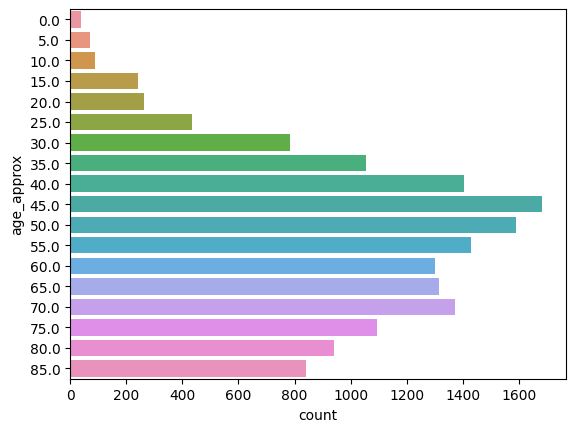

In [84]:
sns.countplot(y='age_approx', data=X_train1)

In [59]:
X_train1.describe()

age_approx           sex
count  15941.000000  16211.000000
mean      53.919139      0.553328
std       18.134149      0.525750
min        0.000000      0.000000
25%       40.000000      0.000000
50%       55.000000      1.000000
75%       70.000000      1.000000
max       85.000000      2.000000

In [60]:
X_train1.mode()

age_approx  sex
0        45.0  1.0

In [61]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer

SEM = SimpleImputer(strategy = 'mean')
scaler = MinMaxScaler()

pipe = Pipeline([('SEM', SEM),('scaler', scaler)])

In [62]:
ct = make_column_transformer((pipe,['age_approx']),remainder='passthrough')

In [63]:
X_transformed_train = pd.DataFrame(ct.fit_transform(X_train1))
X_transformed_train.columns = X_train1.columns

X_transformed_valid = pd.DataFrame(ct.transform(X_valid1))
X_transformed_valid.columns = X_valid1.columns

X_transformed_test = pd.DataFrame(ct.transform(X_test1))
X_transformed_test.columns = X_test1.columns

In [64]:
X_transformed_train.sample(5)

age_approx  sex
4348    0.588235  1.0
103     0.647059  1.0
6975    0.882353  1.0
6682    0.588235  1.0
6853    0.941176  0.0

In [65]:
sklearn_weights=class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train1),
                                        y = y_train1)

sklearn_weights=dict(enumerate(sklearn_weights))

In [66]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(30, activation=tf.keras.activations.tanh, input_shape=(2, )))
model.add(tf.keras.layers.Dense(10, activation=tf.keras.activations.tanh))
model.add(tf.keras.layers.Dense(5, activation=tf.keras.activations.tanh))
model.add(tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid))

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')
)

from tensorflow.keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience=10)
          
model.fit(X_transformed_train,y_train1,validation_data=(X_transformed_valid, y_valid1),epochs=200,callbacks=[early_stopping_monitor],class_weight=sklearn_weights)      

Epoch 1/200
507/507 [==============================] - 5s 8ms/step - loss: 0.6774 - binary_accuracy: 0.5375 - val_loss: 0.6790 - val_binary_accuracy: 0.5625
Epoch 2/200
507/507 [==============================] - 4s 8ms/step - loss: 0.6704 - binary_accuracy: 0.5546 - val_loss: 0.6078 - val_binary_accuracy: 0.6509
Epoch 3/200
507/507 [==============================] - 4s 8ms/step - loss: 0.6688 - binary_accuracy: 0.5441 - val_loss: 0.6823 - val_binary_accuracy: 0.5051
Epoch 4/200
507/507 [==============================] - 4s 8ms/step - loss: 0.6674 - binary_accuracy: 0.5369 - val_loss: 0.6833 - val_binary_accuracy: 0.5043
Epoch 5/200
507/507 [==============================] - 4s 8ms/step - loss: 0.6666 - binary_accuracy: 0.5306 - val_loss: 0.6502 - val_binary_accuracy: 0.5625
Epoch 6/200
507/507 [==============================] - 4s 8ms/step - loss: 0.6660 - binary_accuracy: 0.5287 - val_loss: 0.6543 - val_binary_accuracy: 0.5443
Epoch 7/200
507/507 [==============================] - 4s 

In [67]:
model.evaluate(X_transformed_test, y_test1)

159/159 [==============================] - 1s 5ms/step - loss: 0.6335 - binary_accuracy: 0.5996


[0.6335444450378418, 0.5995658040046692]

#### accuracy isn't good for the numerical features

# concatinating two models, one for images and one for numerical features

In [68]:
#Preparing Data first
XXX.sample(5)

age_approx  sex
479           NaN  2.0
11256        40.0  0.0
22330        80.0  1.0
10210        65.0  0.0
1202         60.0  1.0

In [69]:
same_size_numeric_train_data = pd.merge(XXX, y_train, left_index=True, right_index=True)
same_size_numeric_val_data = pd.merge(XXX, y_valid, left_index=True, right_index=True)
same_size_numeric_test_data = pd.merge(XXX, y_test, left_index=True, right_index=True)

y_train11= same_size_numeric_train_data ['target']
same_size_numeric_train_data = same_size_numeric_train_data.drop(['target'], axis = 1)

y_test11 = same_size_numeric_test_data['target']
same_size_numeric_test_data = same_size_numeric_test_data.drop(['target'], axis = 1)

y_valid11 = same_size_numeric_val_data ['target']
same_size_numeric_val_data = same_size_numeric_val_data.drop(['target'], axis = 1)


In [70]:
same_size_numeric_test_data.head()

age_approx  sex
2         60.0  0.0
6         25.0  0.0
77         NaN  2.0
79         NaN  2.0
97         NaN  2.0

In [71]:
#Changing null values in Age columns with the mean
SEM = SimpleImputer(strategy = 'mean')

X_transformed_trainn = pd.DataFrame(SEM.fit_transform(same_size_numeric_train_data))
X_transformed_trainn.columns = same_size_numeric_train_data.columns

X_transformed_validd = pd.DataFrame(SEM.transform(same_size_numeric_val_data))
X_transformed_validd.columns = same_size_numeric_val_data.columns

X_transformed_testt = pd.DataFrame(SEM.transform(same_size_numeric_test_data))
X_transformed_testt.columns = same_size_numeric_test_data.columns

In [72]:
print("X_train : " + str(X_train.shape))
print("X_transformed_train : " + str(X_transformed_trainn.shape))
print("X_valid : " + str(X_valid.shape))
print("X_transformed_valid : " + str(X_transformed_validd.shape))
print("X_test : " + str(X_test.shape))
print("X_transformed_test11 : " + str(X_transformed_testt.shape))
print("y_train : " + str(y_train.shape))
print("y_train11 : " + str(y_train1.shape))
print("y_valid : " + str(y_valid.shape))
print("y_valid11 : " + str(y_valid1.shape))
print("y_test : " + str(y_test.shape))
print("y_test11 : " + str(y_valid1.shape))

X_train : (3241, 128, 128, 3)
X_transformed_train : (3241, 2)
X_valid : (811, 128, 128, 3)
X_transformed_valid : (811, 2)
X_test : (1014,)
X_transformed_test11 : (1014, 2)
y_train : (3241,)
y_train11 : (16211,)
y_valid : (811,)
y_valid11 : (4053,)
y_test : (1014,)
y_test11 : (4053,)


In [12]:
from keras.models import Model
model = Sequential()
IN = layers.Input(shape=(128,128,3))
COV1 = Conv2D(32, (3,3), activation = 'relu')(IN)
MAX1 = MaxPooling2D(2,2)(COV1)

COV2 = Conv2D(64, (3,3), activation = 'relu')(MAX1)
MAX2 = MaxPooling2D(2,2)(COV2)

DR1 = Dropout(0.2)(MAX2)

COV3 = Conv2D(128, (3,3), activation = 'relu')(DR1)
MAX3 = MaxPooling2D(2,2)(COV3)
DR2 = Dropout(0.2)(MAX3)

COV4 = Conv2D(256, (3,3), activation = 'relu')(DR2)
MAX4 = MaxPooling2D(2,2)(COV4)

F1 = Flatten()(MAX4)

In [13]:
IN2 = layers.Input(shape=(2,), name="IN2")
al_1 = Dense(30, activation = "relu",name ="a_layer_1")(IN2)
al_2 = Dense(10, activation="relu",name ="a_layer_2")(al_1)
al_3 = Dense(5, activation="relu",name ="a_layer_3")(al_2)

In [14]:
concatenated = concatenate([F1, al_3])

In [15]:
output = Dense(1, activation='sigmoid')(concatenated)

In [16]:
model_final = Model(inputs=[IN, IN2], outputs=[output])

In [17]:
model_final.compile(loss = 'binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),metrics=tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'))

In [79]:
early_stopping_monitor = EarlyStopping(patience=10)
results = model_final.fit([X_train, X_transformed_trainn], [y_train, y_train11], epochs = 200, validation_data = ([X_valid, X_transformed_validd],[y_valid ,y_valid11]),callbacks=[early_stopping_monitor])

Epoch 1/200
102/102 [==============================] - 6s 41ms/step - loss: 0.4891 - binary_accuracy: 0.8106 - val_loss: 0.5051 - val_binary_accuracy: 0.8175
Epoch 2/200
102/102 [==============================] - 3s 32ms/step - loss: 0.4692 - binary_accuracy: 0.8164 - val_loss: 0.4625 - val_binary_accuracy: 0.8175
Epoch 3/200
102/102 [==============================] - 3s 32ms/step - loss: 0.4671 - binary_accuracy: 0.8180 - val_loss: 0.4704 - val_binary_accuracy: 0.8200
Epoch 4/200
102/102 [==============================] - 3s 32ms/step - loss: 0.4609 - binary_accuracy: 0.8173 - val_loss: 0.4610 - val_binary_accuracy: 0.8187
Epoch 5/200
102/102 [==============================] - 3s 31ms/step - loss: 0.4581 - binary_accuracy: 0.8186 - val_loss: 0.4452 - val_binary_accuracy: 0.8286
Epoch 6/200
102/102 [==============================] - 3s 32ms/step - loss: 0.4578 - binary_accuracy: 0.8183 - val_loss: 0.4402 - val_binary_accuracy: 0.8274
Epoch 7/200
102/102 [==============================]

In [80]:
test_loss , test_acc = model_final.evaluate([x_test_arr, X_transformed_testt],[y_test ,y_test11])
print('Loss : '+ str(test_loss))
print('Accuracy : '+ str(test_acc))

32/32 [==============================] - 0s 14ms/step - loss: 0.3984 - binary_accuracy: 0.8452
Loss : 0.39844390749931335
Accuracy : 0.8451676368713379


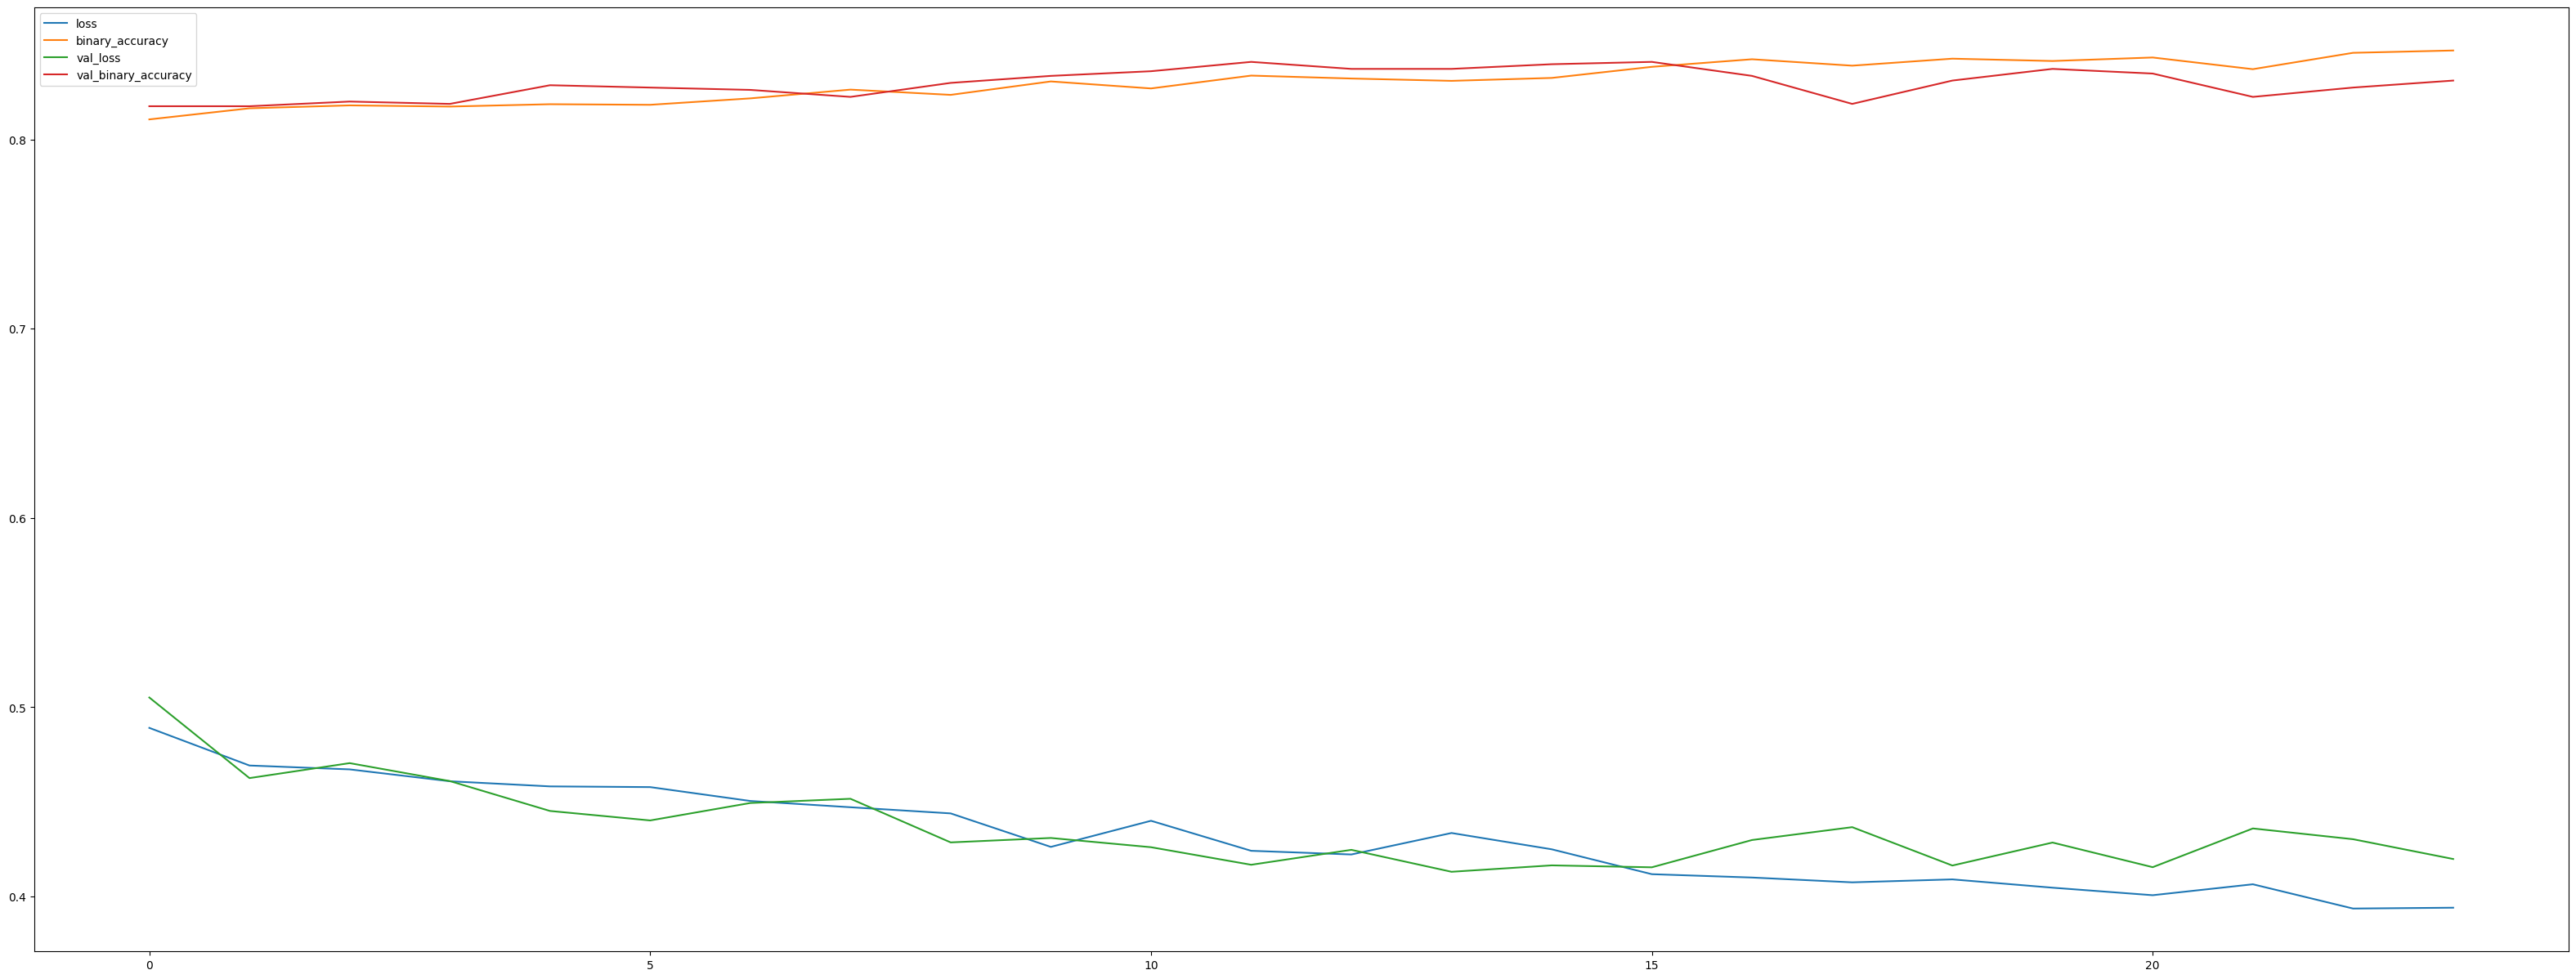

In [81]:
pd.DataFrame(results.history).plot(figsize=(40,15))
plt.show()

# concatinating cnn model (Images) and Dense model (age, sex) gives a better accuracy, note that we only took 20% of the data, 100% of the data should give a much better testing accuracy than 84%